In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import multi_gpu_model
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.contrib.keras.api.keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.
/home/stand/anaconda3/envs/Path/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stand/anaconda3/envs/Path/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stand/anaconda3/envs/Path/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stand/anaconda3/envs/Pa

In [2]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type, model_name):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="right")
        plt.title(model_name+' Training Curve')
        plt.savefig(model_name+'.png',dpi=300)

In [3]:
# path to the model weights files.
model_name = 'conductor_for_inde'
full_model_weights_path = '/media/disk1/Necrosis/model/'+ model_name + '_weight.h5'
full_model_path = '/media/disk1/Necrosis/model/'+ model_name + '_model.h5'
# dimensions of our images.
img_width, img_height = 256, 256

train_data_dir = 'conductor_image/train_contest'
validation_data_dir = 'conductor_image/test_contest'
nb_train_samples = len([f for f in os.listdir(train_data_dir+'/defect') if f.endswith('bmp')])+len([f for f in os.listdir(train_data_dir+'/good_all') if f.endswith('bmp')])
nb_validation_samples = len([f for f in os.listdir(validation_data_dir+'/defect') if f.endswith('bmp')])+len([f for f in os.listdir(validation_data_dir+'/good_all') if f.endswith('bmp')])
epochs = 50
batch_size = 8

In [4]:
input_tensor = Input(shape=(img_height, img_width, 3))
base_model = applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')
# build top model
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dense(2, activation='softmax', name='predictions')(x)
# stitch together
model = Model(inputs= base_model.input, outputs=x)

# inspect
model.summary()

Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________________

__________________________________________________________________________________________________
block17_19_conv (Conv2D)        (None, 14, 14, 1088) 418880      block17_19_mixed[0][0]           
__________________________________________________________________________________________________
block17_19 (Lambda)             (None, 14, 14, 1088) 0           block17_18_ac[0][0]              
                                                                 block17_19_conv[0][0]            
__________________________________________________________________________________________________
block17_19_ac (Activation)      (None, 14, 14, 1088) 0           block17_19[0][0]                 
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 14, 14, 128)  139264      block17_19_ac[0][0]              
__________________________________________________________________________________________________
batch_norm

Found 24121 images belonging to 2 classes.
Found 6892 images belonging to 2 classes.
Epoch 1/50
3016/3015 [==============================] - 754s 250ms/step - loss: 0.6598 - acc: 0.8198 - val_loss: 0.3236 - val_acc: 0.8833

Epoch 00001: val_acc improved from -inf to 0.88334, saving model to /media/disk1/Necrosis/model/conductor_for_inde_weights-improvement-01-0.88.hdf5
Epoch 2/50
3016/3015 [==============================] - 739s 245ms/step - loss: 0.3487 - acc: 0.9136 - val_loss: 0.1305 - val_acc: 0.9540

Epoch 00002: val_acc improved from 0.88334 to 0.95400, saving model to /media/disk1/Necrosis/model/conductor_for_inde_weights-improvement-02-0.95.hdf5
Epoch 3/50
3016/3015 [==============================] - 747s 248ms/step - loss: 0.2414 - acc: 0.9434 - val_loss: 0.1065 - val_acc: 0.9652

Epoch 00003: val_acc improved from 0.95400 to 0.96518, saving model to /media/disk1/Necrosis/model/conductor_for_inde_weights-improvement-03-0.97.hdf5
Epoch 4/50
3016/3015 [==========================

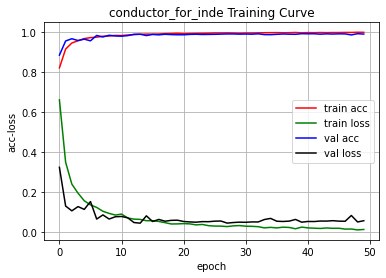

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


history = LossHistory()
filepath="/media/disk1/Necrosis/model/" + model_name + "_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')

class_weight = {0: 1.,
                1: 10.}
# fine-tune the model
hist = model.fit_generator(
       train_generator,
       steps_per_epoch=nb_train_samples/batch_size,
       epochs=epochs,
       validation_data=validation_generator,
       validation_steps=nb_validation_samples/batch_size,
       class_weight=class_weight,
       callbacks=[history,checkpoint])

loss_history_path = os.path.join(model_name +'_loss_history_epoch.log')
myFile = open(loss_history_path, 'w+')
myFile.write(str(hist.history))
myFile.close()
# print model.predict_generator(validation_generator, steps=1)

model.save_weights(full_model_weights_path)

model.save(full_model_path)
history.loss_plot('epoch',model_name)

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [31]:
import os, time
import numpy as np
import pandas as pd
from keras.models import load_model
from PIL import Image
model = load_model('/media/disk1/Necrosis/model/conductor_for_inde_model.h5')
## origin trained model
#model.load_weights('/media/disk1/Necrosis/model/ori_weights.hdf5')
## 10 folders weights of defected images model
model.load_weights('/media/disk1/Necrosis/model/10folder_weights.hdf5')

In [23]:
val_good = 'conductor_image/val_contest/good_all/'
val_defect = 'conductor_image/val_contest/defect/'

In [32]:
from tqdm import tqdm
good_list = [f for f in os.listdir(val_good) if f.endswith('bmp')]
defect_list = [f for f in os.listdir(val_defect) if f.endswith('bmp')]
val_result = pd.DataFrame(columns=['img','label','prediction'])
for i, img_file in enumerate(tqdm(good_list)):
    img = Image.open(val_good+img_file)
    img = img.convert('RGB')
    resize_img = img.resize((256,256),Image.ANTIALIAS)
    resize_arr = np.asarray(resize_img,dtype="float32")
    temp = np.empty((1,256,256,3),dtype="float32")
    temp[0,:,:,:] = resize_arr
    Pred_data = temp.astype('float32')
    Pred_data /= 255.0
    pred_result = model.predict(Pred_data)
    val_result = val_result.append([{'img':img_file,'label':0,'prediction':pred_result[0,0]}],ignore_index=True)

100%|██████████| 2742/2742 [02:27<00:00, 18.63it/s]


In [33]:
for i, img_file in enumerate(tqdm(defect_list)):
    img = Image.open(val_defect+img_file)
    img = img.convert('RGB')
    resize_img = img.resize((256,256),Image.ANTIALIAS)
    resize_arr = np.asarray(resize_img,dtype="float32")
    temp = np.empty((1,256,256,3),dtype="float32")
    temp[0,:,:,:] = resize_arr
    Pred_data = temp.astype('float32')
    Pred_data /= 255.0
    pred_result = model.predict(Pred_data)
    val_result = val_result.append([{'img':img_file,'label':1,'prediction':pred_result[0,0]}],ignore_index=True)

100%|██████████| 704/704 [00:33<00:00, 20.71it/s]


In [17]:
val_result

,img,label,prediction
0,WEP93729693A_18-5BW-ITISA47-1_78_3.bmp,0,1.530178e-08
1,WEP937297R3A_31-W1A-ITISA73-2_164_4.bmp,0,2.691834e-06
2,WEL930041D5A_05-WV3-ITISA13-1_344_4.bmp,0,6.975555e-06
3,WEP93714311A_06-TVW-ITISA35-1_689_3.bmp,0,1.379440e-09
4,WEP93714412A_01-WDV-ITISA50-1_37_3.bmp,0,4.953213e-08
...,...,...,...
3441,WEP93836214A_21-APG_ITIS_H72_1_5_2.bmp,1,9.999949e-01
3442,WEP932075H3A_01-APG_ITIS_H46_2_240_3.bmp,1,9.969161e-01
3443,WEP93529071A_04-APG_ITIS_H53_2_467_4.bmp,1,9.999815e-01
3444,WEL932084H5A_48-APG_ITIS_H54_1_209_4.bmp,1,2.127475e-01


In [6]:
from scipy import stats
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

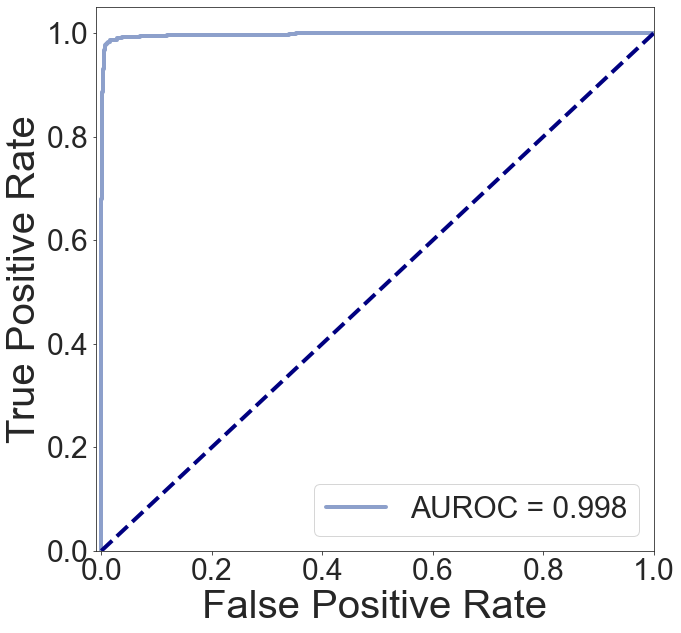

In [38]:
import seaborn as sns
sns.set_style("ticks")
plt.figure(figsize=(10,10))
y = val_result['label'].astype(np.int)
scores = val_result['prediction']
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
roc_auc = roc_auc_score(y, scores)
plt.plot(fpr, tpr,label='AUROC = %0.3f' % roc_auc, linewidth=4, color = "#8da0cb")
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate',fontsize=40)
plt.ylabel('True Positive Rate',fontsize=40)
#plt.title('ROC of 5 models',fontsize=40)
plt.legend(loc="lower right",fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig('ROC_sample_weight_adjust.png',dpi = 300, bbox_inches='tight') 
plt.show()

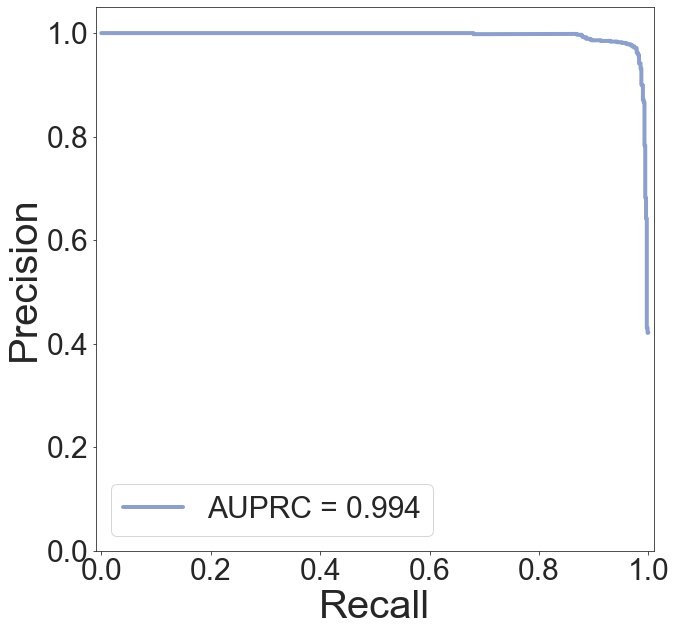

In [34]:
plt.figure(figsize=(10,10))
sns.set_style("ticks")
y = val_result['label'].astype(np.int)
scores = val_result['prediction']
precision, recall, thresholds = precision_recall_curve(y, scores, pos_label=1)
prauc = metrics.auc(recall, precision)
plt.plot(recall, precision,label='AUPRC = %0.3f' % prauc, linewidth=4, color = "#8da0cb")
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=40)
plt.ylabel('Precision',fontsize=40)
#plt.title('PRC of combined models',fontsize=40)
plt.legend(loc="lower left",fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig('PRC_sample_weight_adjust.png',dpi = 300, bbox_inches='tight') 
plt.show()